In [48]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import clear_output

import parcer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from model import *
import importlib
importlib.reload(model)
import math

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler

from grokfast import gradfilter_ma, gradfilter_ema

In [49]:
df = pd.read_csv('my_data.csv')

In [50]:
features = [
    "kalories",
    "proteins",
    "fats",
    "carbohydrates",
    "rating",
    "size",
    "discount",
    "shelf_life",
    "max_storage_temperature",
    "min_storage_temperature",
    "is_by_weight",
    "is_special_offer",
    "storage_temp_range",
    "protein_to_carb_ratio",
    "is_low_carb",
    "kalories_all",
    "proteins_all",
    "fats_all",
    "country_gdp_per_capita",
]

target = "price"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# y_train = np.log(y_train)
# y_test = np.log(y_test)

# scaler = StandardScaler()
# y_train = scaler.fit_transform(y_train)
# y_test = scaler.transform(y_test)

In [51]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

predictions = linear_regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5

print("LinearRegression")
print("Root Mean Squared Error on the test set:", rmse)

LinearRegression
Root Mean Squared Error on the test set: 502.23652625068746


In [32]:
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

predictions = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5

print("RandomForestRegressor")
print("Root Mean Squared Error on the test set:", rmse)

/home/grafstor/.local/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor
Root Mean Squared Error on the test set: 382.09268122809414


In [52]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9919, 19), (2480, 19), (9919, 1), (2480, 1))

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

class MyDataset(Dataset):
    def __init__(self, inp, tgt, device):
        super().__init__()
        self.inp = torch.tensor(inp, dtype=torch.float32, device=device)
        self.tgt = torch.tensor(tgt, dtype=torch.float32, device=device)
        
        self.device = device

    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx):
        return self.inp[idx].clone(), self.tgt[idx].clone()

batch_size = 32

train_dataset = MyDataset(X_train, y_train, device)
test_dataset = MyDataset(X_test, y_test, device)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

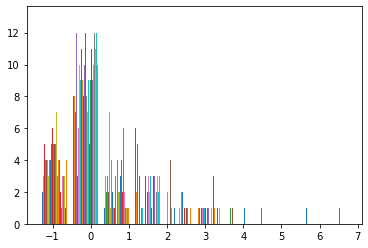

In [54]:
for nums, tgt in train_dl:
    break
plt.hist(nums)
plt.show()

In [55]:
class Model(nn.Module):
    def __init__(
        self,
        dim,
        dropout_p
    ):
        super().__init__()

        self.dim = dim

        self.l1 = nn.Linear(19, dim)
        self.l2 = nn.Linear(dim, dim)
        self.l3 = nn.Linear(dim, dim)
        
        self.out = nn.Linear(dim, 1)
        
        self.dropout = nn.Dropout(dropout_p)
        self.act = nn.LeakyReLU(0.1)
#         self.act = nn.GELU()

    def forward(self, inp):

        h1 = self.dropout(self.act(self.l1(inp)))
        
        h2 = h1 + self.dropout(self.act(self.l2(h1)))
        h3 = h2 + self.dropout(self.act(self.l3(h2)))
        
        out = self.out(h3)
        
        return out


In [60]:
model = Model(
            dim=64*2,
            dropout_p=0.2
        )

opt = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.005*5)
loss_fn = nn.MSELoss()

In [62]:
step = -1
metrics = {'train_loss': [], 'test_loss': []}

def plot_metrics(metrics):
    plt.figure(figsize=(12,4))
    for i, (name, history) in enumerate(sorted(metrics.items())):
        plt.subplot(1, len(metrics), i + 1)
        plt.title(name)
        plt.plot(*zip(*history))
        plt.grid()
    plt.show()

def get_test_loss(model, test_dl):
    with torch.no_grad():
        all_tgt = []
        all_out = []

        for inp, tgt in test_dl:
            out = model(inp)

            all_out.append(out)
            all_tgt.append(tgt)

        all_tgt = torch.cat(all_tgt, dim=0)
        all_out = torch.cat(all_out, dim=0)

        test_mse_loss = loss_fn(all_out, all_tgt)
        test_rmse_loss = test_mse_loss.item() ** 0.5
        return test_rmse_loss

Epoch: 749, step: 232499, loss: 93098.2734375, test_loss: 450.23382813822417, min: 405.5715873924109


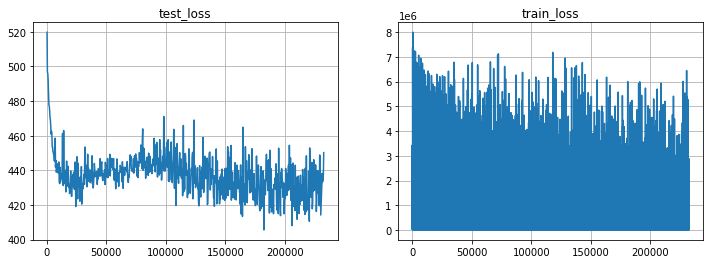

KeyboardInterrupt: 

In [63]:
min_test_loss = float('inf')

alpha = 0.98 
lamb = 2.0
grads = None

for epoch in range(1_000):
    model.train()
    for inp, tgt in train_dl:
        step += 1

        out = model(inp)

        loss = loss_fn(out, tgt)
        

        opt.zero_grad()
            
        loss.backward()
        grads = gradfilter_ema(model, grads=grads, alpha=alpha, lamb=lamb)
        opt.step()
        
        metrics['train_loss'].append((step, loss.item()))

    model.eval()

    test_loss = get_test_loss(model, test_dl)

    metrics['test_loss'].append((step, test_loss))

    min_test_loss = min(min_test_loss, test_loss)

    clear_output()
    print(f'Epoch: {epoch}, step: {step}, loss: {loss.item()}, test_loss: {test_loss}, min: {min_test_loss}')
    plot_metrics(metrics)

**Epoch: 749, step: 232499, loss: 93098.2734375, test_loss: 450.23382813822417, min: 405.5715873924109** 
- Learning minimum ~70 epoch 
- Grokking achived! - ~700 epoch 

For: 
- alpha = 0.98 
- lamb = 2.0
- lr=3e-4
- weight_decay=0.005*5
- dim=64*2
- dropout=0.2